In [2]:
#import library
!pip install yellowbrick
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import seaborn as sns
from sklearn.metrics import silhouette_score,silhouette_samples
import warnings
import re
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML

     |████████████████████████████████| 274 kB 5.4 MB/s eta 0:00:01


In [5]:
#Some basic setting and read in data
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 200
pd.options.display.max_columns = 300
warnings.filterwarnings("ignore")
df_fn = pd.read_csv('/Users/lanjenny/Downloads/fundamentals.csv')
df_sec = pd.read_csv('/Users/lanjenny/Downloads/securities.csv')
df_psa = pd.read_csv('/Users/lanjenny/Downloads/prices-split-adjusted.csv')
df_psa['year'] = pd.DatetimeIndex(df_psa['date']).year
df_psa=df_psa.drop_duplicates(subset=['symbol', 'year'], keep='first')
df_psa=df_psa.sort_values(by=['symbol', 'year'])
df_psa['Changeinprice']=df_psa['close'].pct_change()
df_psa=df_psa[~(df_psa['symbol'].duplicated(keep=False) ^ df_psa['symbol'].duplicated())]
df_psa['year'] = df_psa['year'] - 1
df_psa['nextyear'] = df_psa['year'] - 1
f_dct = {n : re.sub('[^A-Za-z0-9]+','',n) for n in df_fn.columns.values}
df_fn.rename(columns = f_dct,inplace=True)
df_fn['PeriodEnding'] = pd.to_datetime(df_fn['PeriodEnding'])
df_fn['ForYear'] = df_fn['PeriodEnding'].dt.year.astype('category')
fwm = ["TickerSymbol","ForYear","AccountsPayable","AccountsReceivable","GrossProfit","Liabilities","NetCashFlow","OperatingIncome","TotalAssets","TotalEquity","TotalLiabilities","TotalLiabilities&Equity","TotalRevenue","EarningsPerShare"]
to_drop= [x for x in df_fn.columns.values if x not in fwm]
df_fn.drop(columns = to_drop,inplace = True)



print(df_fn.info())
print("The dataset has ",len(df_fn['TickerSymbol'].unique())," unique tickers")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   TickerSymbol        1781 non-null   object  
 1   AccountsPayable     1781 non-null   float64 
 2   AccountsReceivable  1781 non-null   float64 
 3   GrossProfit         1781 non-null   float64 
 4   Liabilities         1781 non-null   float64 
 5   NetCashFlow         1781 non-null   float64 
 6   OperatingIncome     1781 non-null   float64 
 7   TotalAssets         1781 non-null   float64 
 8   TotalEquity         1781 non-null   float64 
 9   TotalLiabilities    1781 non-null   float64 
 10  TotalRevenue        1781 non-null   float64 
 11  ForYear             1781 non-null   category
 12  EarningsPerShare    1562 non-null   float64 
dtypes: category(1), float64(11), object(1)
memory usage: 169.2+ KB
None
The dataset has  448  unique tickers


In [6]:
stockname=df_fn[['TickerSymbol','ForYear']]
df_fn.set_index(['TickerSymbol','ForYear'],inplace=True)
y_col = df_fn.columns[df_fn.isna().any(axis =0)]
fn_pred = df_fn[df_fn.isna().any(axis =1)]
fn_prem = df_fn[~df_fn.isna().any(axis =1)]
index=fn_prem.reset_index()
index=index[['TickerSymbol','ForYear']]
y = fn_prem[y_col]
fn_prem.drop(columns = y_col)


AccountsPayable  AccountsReceivable   GrossProfit  \
TickerSymbol ForYear                                                      
AAL          2012        3.068000e+09        -222000000.0  1.435600e+10   
             2013        4.975000e+09         -93000000.0  1.572400e+10   
             2014        4.668000e+09        -160000000.0  2.703000e+10   
             2015        5.102000e+09         352000000.0  2.989400e+10   
AAP          2012        2.409453e+09         -89482000.0  3.098036e+09   
...                               ...                 ...           ...   
ZION         2014        0.000000e+00                 0.0  0.000000e+00   
             2015        0.000000e+00                 0.0  0.000000e+00   
ZTS          2013        1.381000e+09         -99000000.0  2.892000e+09   
             2014        1.071000e+09          69000000.0  3.068000e+09   
             2015        1.313000e+09         -58000000.0  3.027000e+09   

                       Liabilities  NetCashFlow  OperatingIncome  \
TickerSymbol ForYear                                               
AAL          2012     4.730000e+08  197000000.0     1.480000e+08   
             2013    -2.350000e+08  660000000.0     1.399000e+09   
             2014    -1.026000e+09 -146000000.0     4.249000e+09   
             2015    -6.330000e+08 -604000000.0     6.204000e+09   
AAP          2012     4.263230e+08  540210000.0     6.573150e+08   
...                            ...          ...              ...   
ZION         2014     4.263600e+07 -331115000.0     0.000000e+00   
             2015    -5.759000e+06  -43623000.0     0.000000e+00   
ZTS          2013     1.670000e+08  293000000.0     7.940000e+08   
             2014    -1.970000e+08  272000000.0     9.440000e+08   
             2015     8.700000e+07  272000000.0     7.500000e+08   

                       TotalAssets   TotalEquity  TotalLiabilities  \
TickerSymbol ForYear                                                 
AAL          2012     2.351000e+10 -7.987000e+09      2.489100e+10   
             2013     4.227800e+10 -2.731000e+09      4.500900e+10   
             2014     4.322500e+10  2.021000e+09      4.120400e+10   
             2015     4.841500e+10  5.635000e+09      4.278000e+10   
AAP          2012     4.613814e+09  1.210694e+09      3.403120e+09   
...                            ...           ...               ...   
ZION         2014     5.720887e+10  7.369530e+09      4.983934e+10   
             2015     5.966952e+10  7.507519e+09      5.216201e+10   
ZTS          2013     6.558000e+09  9.400000e+08      5.618000e+09   
             2014     6.588000e+09  1.311000e+09      5.277000e+09   
             2015     7.913000e+09  1.068000e+09      6.845000e+09   

                      TotalRevenue  
TickerSymbol ForYear                
AAL          2012     2.485500e+10  
             2013     2.674300e+10  
             2014     4.265000e+10  
             2015     4.099000e+10  
AAP          2012     6.205003e+09  
...                            ...  
ZION         2014     2.361631e+09  
             2015     2.210591e+09  
ZTS          2013     4.561000e+09  
             2014     4.785000e+09  
             2015     4.765000e+09  

[1562 rows x 10 columns]

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

Text(0.5, 0, 'Values of K')

Text(0, 0.5, 'Sum of squared distances/Inertia')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

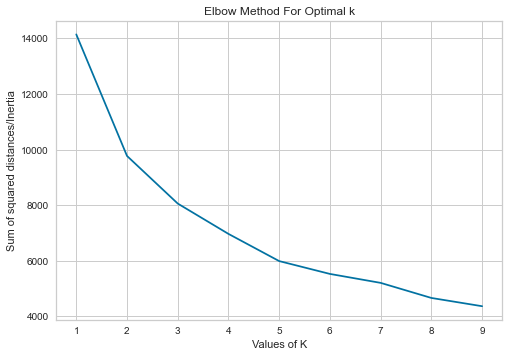

In [7]:
ss = StandardScaler()
X = ss.fit_transform(fn_prem)
#X.index=fn_prem.index
index=index.to_numpy()
X_train, X_test, y_train, y_test ,index_train,index_test= train_test_split( X,y,index, test_size = 0.2)
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()




SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=2))

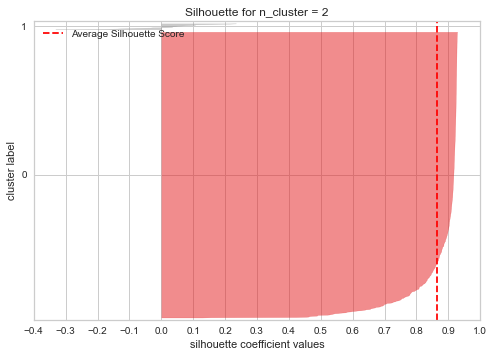

<AxesSubplot:title={'center':'Silhouette for n_cluster = 2'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=3))

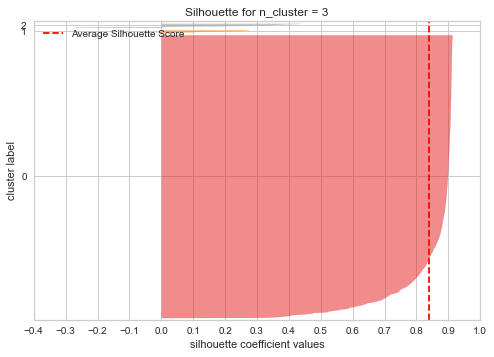

<AxesSubplot:title={'center':'Silhouette for n_cluster = 3'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=4))

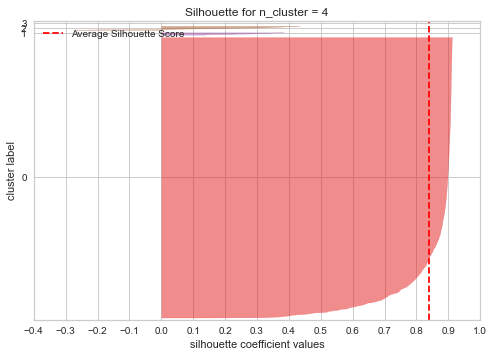

<AxesSubplot:title={'center':'Silhouette for n_cluster = 4'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=5))

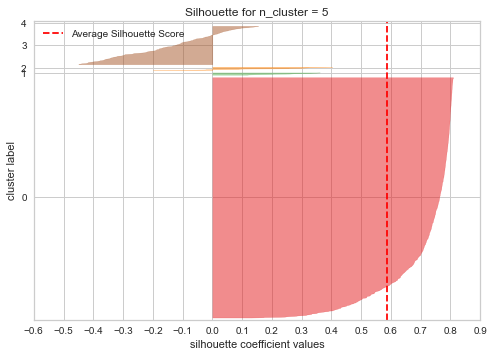

<AxesSubplot:title={'center':'Silhouette for n_cluster = 5'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=6))

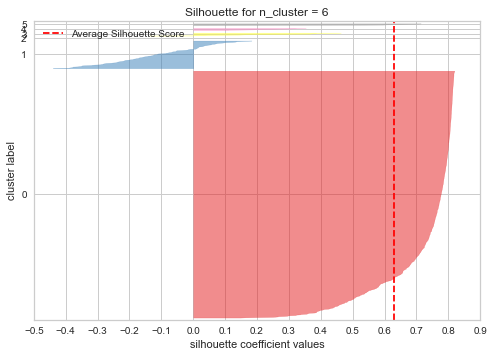

<AxesSubplot:title={'center':'Silhouette for n_cluster = 6'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=7))

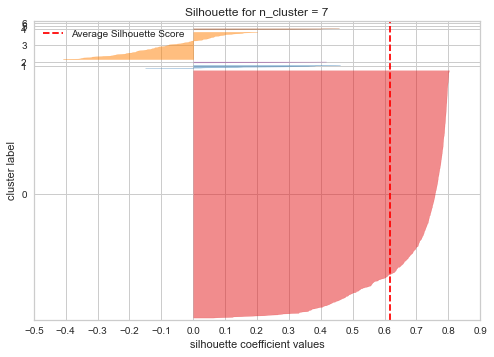

<AxesSubplot:title={'center':'Silhouette for n_cluster = 7'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans())

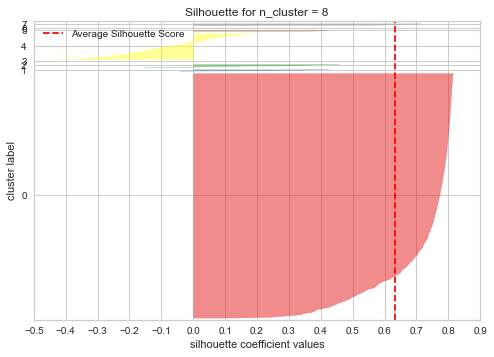

<AxesSubplot:title={'center':'Silhouette for n_cluster = 8'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=9))

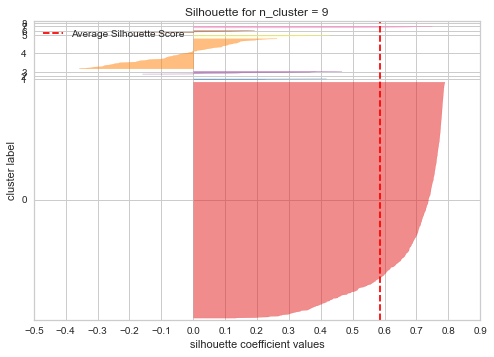

<AxesSubplot:title={'center':'Silhouette for n_cluster = 9'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=10))

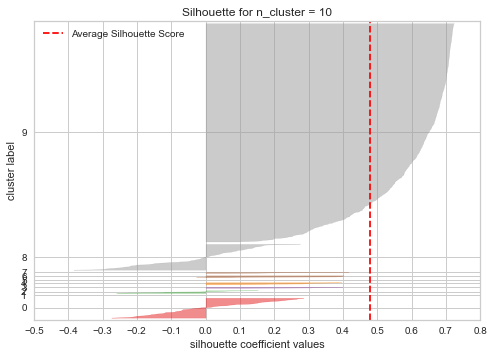

<AxesSubplot:title={'center':'Silhouette for n_cluster = 10'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [8]:
for i in range(2,11):
    model = SilhouetteVisualizer(KMeans(i),title = 'Silhouette for n_cluster = '+str(i))
    model.fit(X_train)
    model.show()
colors = ['orange', 'blue']
km = KMeans(n_clusters=2).fit(X_train)

labels = km.labels_
ctr = km.cluster_centers_


0    1222
1      27
Name: Group, dtype: int64
Plot for return of next year again group


<AxesSubplot:xlabel='Group', ylabel='Changeinprice'>

   Group  Changeinprice
0      0       0.120518
1      1       0.071872
Ttest for predict price next year
Ttest_indResult(statistic=1.2624031642837308, pvalue=0.22084955392975258)
Graph of relationship between return on stock and group


<AxesSubplot:xlabel='Group', ylabel='Changeinprice'>

   Group  Changeinprice
0      0       0.160647
1      1       0.126680
Ttest for same year
Ttest_indResult(statistic=0.6363580355155161, pvalue=0.5302337269807312)
    Group Symbol  year        date symbol        open       close         low  \
0       1    XOM  2013  2014-01-02    XOM  100.599998   99.750000   99.389999   
1       1    JPM  2012  2013-01-02    JPM   44.980000   44.660000   44.220001   
2       1      C  2012  2013-01-02      C   40.910000   41.250000   40.700001   
3       1    WMT  2015  2016-01-04    WMT   60.500000   61.459999   60.360001   
4       1    WFC  2015  2016-01-04    WFC   53.090000   52.910000   52.299999   
5       1    JPM  2015  2016-01-04    JPM   63.950001   63.619999   63.009998   
6       1   AAPL  2013  2014-01-02   AAPL   79.382858   79.018570   78.860001   
7       1    XOM  2012  2013-01-02    XOM   87.790001   88.709999   87.239998   
8       1    WMT  2013  2014-01-02    WMT   78.720001   78.910004   78.500000   
9       1     VZ  2014  2

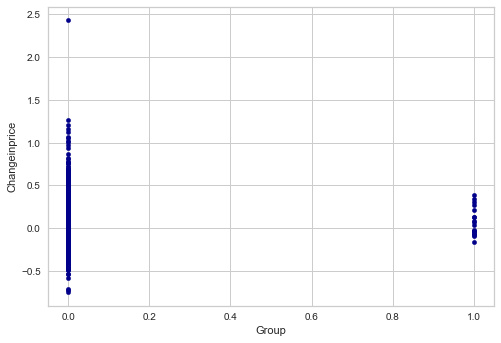

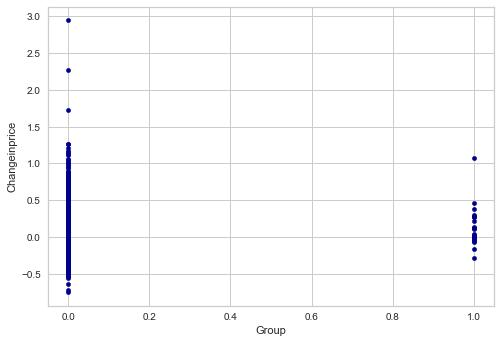

In [9]:
#Result of the training group
df = pd.DataFrame(labels, columns = ['Group'])
df2=pd.DataFrame(index_train,columns=['Symbol','year'])
df=pd.merge(df, df2, left_index=True, right_index=True)
print(df.Group.value_counts())
new_df = pd.merge(df,df_psa ,  how='inner', left_on=['Symbol','year'], right_on = ['symbol','nextyear'])
print('Plot for return of next year again group')
new_df.plot.scatter(x='Group',y='Changeinprice',c='DarkBlue')

print((new_df.groupby('Group', as_index=False)['Changeinprice'].mean()))
df1 = new_df[new_df['Group'] < 1]
df2 = new_df[new_df['Group'] == 1]
from scipy import stats
print('Ttest for predict price next year')
print(stats.ttest_ind(df1['Changeinprice'], df2['Changeinprice'], equal_var=False))
new_df = pd.merge(df,df_psa ,  how='inner', left_on=['Symbol','year'], right_on = ['symbol','year'])
print('Graph of relationship between return on stock and group')
new_df.plot.scatter(x='Group',y='Changeinprice',c='DarkBlue')
print((new_df.groupby('Group', as_index=False)['Changeinprice'].mean()))
df1 = new_df[new_df['Group'] < 1]
df2 = new_df[new_df['Group'] == 1]
from scipy import stats
print('Ttest for same year')
print(stats.ttest_ind(df1['Changeinprice'], df2['Changeinprice'], equal_var=False))
if df1['Group'].count()<df2['Group'].count():
    new_df = pd.merge(df1,df_sec ,  how='left', left_on=['Symbol'], right_on = ['Ticker symbol'])
else:
    new_df = pd.merge(df2,df_sec ,  how='left', left_on=['Symbol'], right_on = ['Ticker symbol'])


print(new_df)





test
0    1222
1      27
Name: Group, dtype: int64
Graph of relationship between future return of stock and group


<AxesSubplot:xlabel='Group', ylabel='Changeinprice'>

   Group  Changeinprice
0      0       0.090511
1      1      -0.016193
Ttest_indResult(statistic=1.0058128944492546, pvalue=0.3680291096718406)
Graph of relationship between return on stock and group


<AxesSubplot:xlabel='Group', ylabel='Changeinprice'>

   Group  Changeinprice
0      0       0.131324
1      1       0.090160
Ttest_indResult(statistic=0.7020452025491666, pvalue=0.5055698552465833)


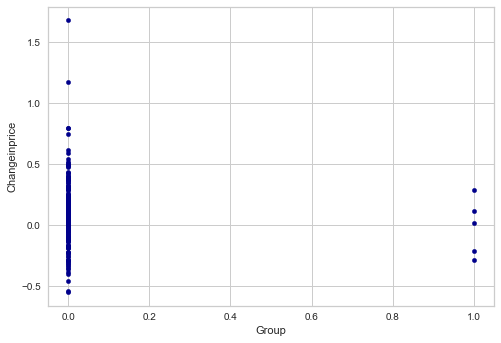

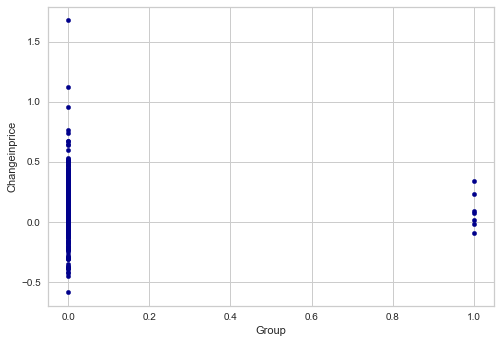

In [10]:
print('test')

labels=km.predict(X_test)
df3 = pd.DataFrame(labels, columns = ['Group'])
df2=pd.DataFrame(index_test,columns=['Symbol','year'])
df3=pd.merge(df3, df2, left_index=True, right_index=True)
print(df.Group.value_counts())
print('Graph of relationship between future return of stock and group')
new_df = pd.merge(df3,df_psa ,  how='inner', left_on=['Symbol','year'], right_on = ['symbol','nextyear'])
new_df.plot.scatter(x='Group',y='Changeinprice',c='DarkBlue')
print((new_df.groupby('Group', as_index=False)['Changeinprice'].mean()))
df1 = new_df[new_df['Group'] < 1]
df2 = new_df[new_df['Group'] == 1]
from scipy import stats
print(stats.ttest_ind(df1['Changeinprice'], df2['Changeinprice'], equal_var=False))
new_df = pd.merge(df3,df_psa ,  how='inner', left_on=['Symbol','year'], right_on = ['symbol','year'])
print('Graph of relationship between return on stock and group')
new_df.plot.scatter(x='Group',y='Changeinprice',c='DarkBlue')
print((new_df.groupby('Group', as_index=False)['Changeinprice'].mean()))
df1 = new_df[new_df['Group'] < 1]
df2 = new_df[new_df['Group'] == 1]
from scipy import stats
print(stats.ttest_ind(df1['Changeinprice'], df2['Changeinprice'], equal_var=False))
if df1['Group'].count()<df2['Group'].count():
    new_df = pd.merge(df1,df_sec ,  how='left', left_on=['Symbol'], right_on = ['Ticker symbol'])
else:
    new_df = pd.merge(df2,df_sec ,  how='left', left_on=['Symbol'], right_on = ['Ticker symbol'])


